In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

X, y = datasets.make_classification(n_samples=1000, 
                                    n_informative=2, 
                                    n_features=2, 
                                    n_redundant=0,
                                    n_clusters_per_class=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [2]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf_node(self):
        return self.value is not None

In [3]:
class DecisionTree:
    def __init__(self, min_samples=2, max_depth=10):
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.tree = []
    
    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)
    
    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])
    
    def most_common(self, y): 
        labels = np.unique(y)       
        count = [list(y).count(i) for i in labels]        
        return labels[np.argmax(count)]
    
    def entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        entr = -np.sum([p * np.log2(p) for p in ps if p > 0])
        gini = np.sum([p * (1 - p) for p in ps])
        return entr
    
    def best_split(self, X, y):
        best_feature, best_threshold = None, None
        best_gain = -1
        
        for i in range(X.shape[1]):
            thresholds = np.unique(X[:, i])
            for threshold in thresholds:
                gain = self.information_gain(X[:, i], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = i
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def information_gain(self, X_column, y, threshold):        
        if len(np.unique(y)) == 1: 
            return -1
        
        n = len(y)
        parent = self.entropy(y)
        
        left_indexes = np.argwhere(X_column <= threshold).flatten()
        right_indexes = np.argwhere(X_column > threshold).flatten()
        
#         if len(left_indexes) == 0 or len(right_indexes) == 0:
#             return 0
    
        e_l, n_l = self.entropy(y[left_indexes]), len(left_indexes)
        e_r, n_r = self.entropy(y[right_indexes]), len(right_indexes)
        
        child = (n_l / n) * e_l + (n_r / n) * e_r
        return parent - child
    
    def grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        n_labels = len(np.unique(y))

        if n_samples < self.min_samples or n_labels == 1 or depth >= self.max_depth:
            return Node(value=self.most_common(y))
        
        best_feature, best_threshold = self.best_split(X, y)
        
        left_indexes = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        right_indexes = np.argwhere(X[:, best_feature] > best_threshold).flatten()
        
        left = self.grow_tree(X[left_indexes, :], y[left_indexes], depth+1)
        right = self.grow_tree(X[right_indexes, :], y[right_indexes], depth+1)
        
        return Node(best_feature, best_threshold, left, right)
    
    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value
        
        if x[tree.feature] <= tree.threshold:
            return self.travers_tree(x, tree.left)

        return self.travers_tree(x, tree.right)

In [4]:
def dt_back_ground(x_min, x_max, y_min, y_max, model):
    step = 100

    xx, yy = np.meshgrid(
                        np.arange(x_min, x_max + (x_max-x_min) / step, (x_max-x_min) / step),
                        np.arange(y_min, y_max + (y_max-y_min) / step, (y_max-y_min) / step)
                        )

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)    
    
    return xx, yy, Z

In [5]:
dt_train_score = []
dt_test_score = []
depth = []

for i in range(1, 10, 1):
    depth.append(i)
    dt_clf = DecisionTree(max_depth=i)
    dt_clf.fit(X_train, y_train)
    
    predict = dt_clf.predict(X_train)
    dt_train_score.append(np.sum(predict == y_train) / len(y_train))
    
    predict = dt_clf.predict(X_test)
    dt_test_score.append(np.sum(predict == y_test) / len(y_test))

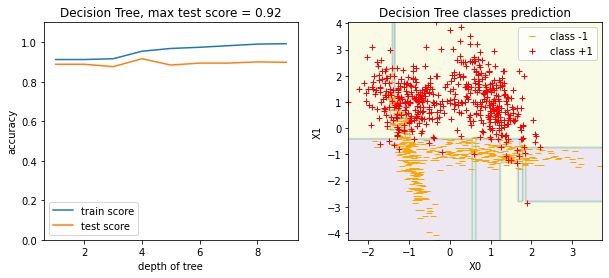

In [6]:
def plot_the_couple():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    axes[0].plot(depth, dt_train_score, label="train score")
    axes[0].plot(depth, dt_test_score, label="test score")

    axes[0].set_ylabel("accuracy")
    axes[0].set_xlabel("depth of tree")
    axes[0].set_title("Decision Tree, max test score = " + str(round(max(dt_test_score), 2)))
    axes[0].set_ylim(0, 1.1)
    axes[0].legend()

    xx, yy, Z = dt_back_ground(min(X[:, 0]), max(X[:, 0]), min(X[:, 1]), max(X[:, 1]), dt_clf)

    axes[1].plot(X[y==0, 0], X[y==0, 1], "_", color='orange', label="class -1")
    axes[1].plot(X[y==1, 0], X[y==1, 1], "+", color='red', label="class +1")
    axes[1].set_xlabel("X0")
    axes[1].set_ylabel("X1")
    axes[1].set_title("Decision Tree classes prediction")
    axes[1].contourf(xx, yy, Z, alpha=0.1)

    axes[1].legend()
    plt.show()
    
plot_the_couple()

In [7]:
class AdaBoost:
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.trees = []
        self.asay = []
        self.weights = []
        self.X = []
        self.y = []
        
    def fit(self, X, y):
        n = len(y)
        w = np.ones(n) / n
        
        for i in range(self.n_estimators):
            tree = DecisionTree(max_depth=1)
            tree.fit(X, y)
            self.trees.append(tree)
            
            self.X.append(X)
            self.y.append(y)
            
            labels = tree.predict(X)
            missed = np.not_equal(labels, y).astype("int")
            
            total_error = sum(w * missed)
            amount_of_say = 0.5 * np.log((1 - total_error) / (total_error + 1e-7))
            
            missed = missed * 2 - 1
            w *= np.exp(amount_of_say * missed)
            w /= np.sum(w)
            
            self.asay.append(amount_of_say)
            self.weights.append(w.copy())
    
            for j in range(1, n):
                w[j] = w[j] + w[j - 1]
            
            indexes = [np.where(w >= np.random.random())[0][0] for _ in range(n)]
            
            X = X[indexes].copy()
            y = y[indexes].copy()
            w = np.ones(n) / n
            
    def predict(self, X, n=None):
        if n is None:
            n = self.n_estimators
        predictions = np.zeros(X.shape[0])
        
        for i in range(n):
            predict = (np.array(self.trees[i].predict(X)) * 2 - 1) * self.asay[i]
            predictions += predict
        
        return np.where(predictions <= 0, 0, 1)
    
    def weak_predict(self, X, n):
        return self.trees[n].predict(X)
    
    def score(self, predicted, y):
        return np.sum(predicted == y) / len(y)

In [8]:
ab_clf = AdaBoost(n_estimators=20)
ab_clf.fit(X_train, y_train)

predicted = ab_clf.predict(X_test)
print(ab_clf.score(predicted, y_test))

0.874


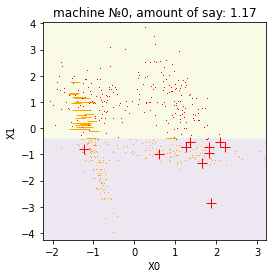

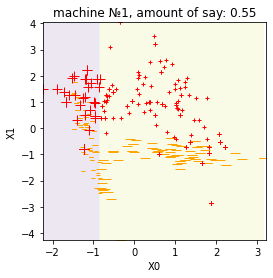

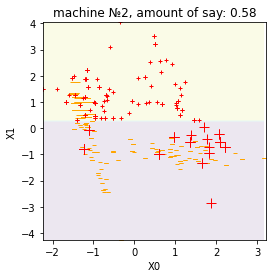

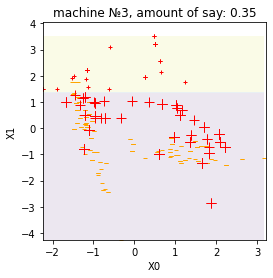

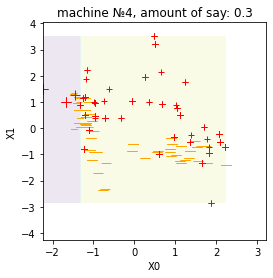

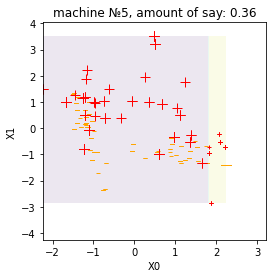

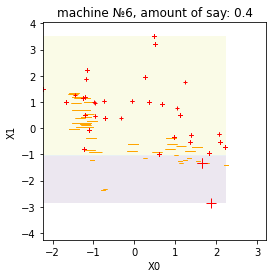

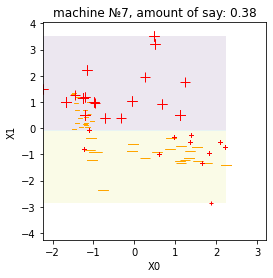

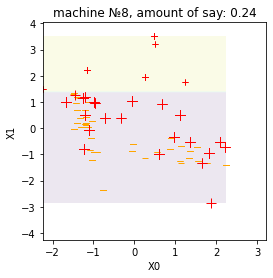

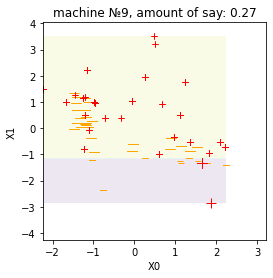

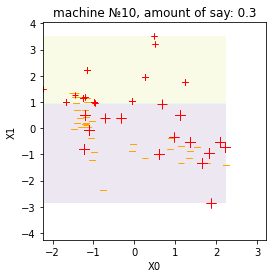

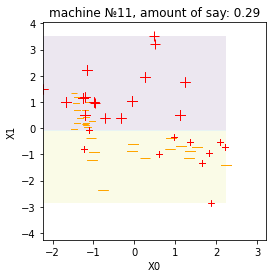

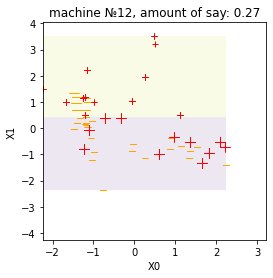

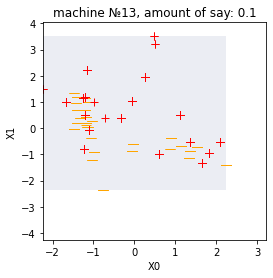

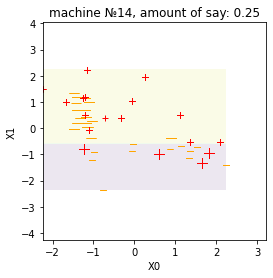

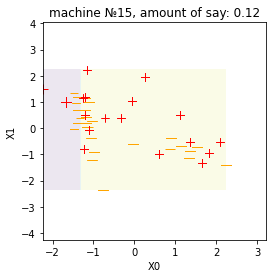

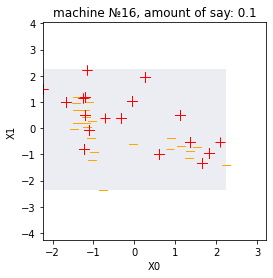

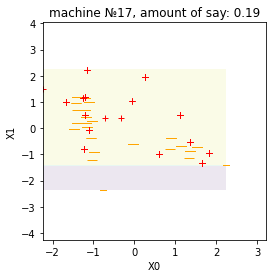

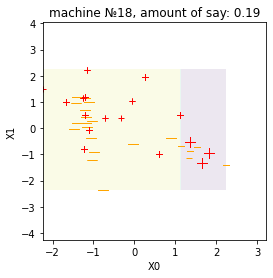

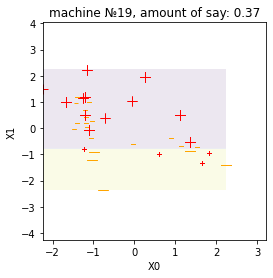

In [9]:
def ab_back_ground(x_min, x_max, y_min, y_max, model, n):
    step = 100

    xx, yy = np.meshgrid(
                        np.arange(x_min, x_max + (x_max-x_min) / step, (x_max-x_min) / step),
                        np.arange(y_min, y_max + (y_max-y_min) / step, (y_max-y_min) / step)
                        )

    Z = model.weak_predict(np.c_[xx.ravel(), yy.ravel()], n)
    Z = Z.reshape(xx.shape)    
    
    return xx, yy, Z

for i in range(0, ab_clf.n_estimators):
    X_ = ab_clf.X[i]
    y_ = ab_clf.y[i]
    xx, yy, Z = ab_back_ground(min(X_[:, 0]), max(X_[:, 0]), 
                            min(X_[:, 1]), max(X_[:, 1]), ab_clf, i)

    ind0 = np.where(y_==0)[0]
    ind1 = np.where(y_==1)[0]

    plt.subplots(figsize=(4, 4))
   
    wmax = max(ab_clf.weights[i][:])

    for j in ind0:
        plt.plot(X_[j, 0], X_[j, 1], "_", color='orange',
                 markersize=10 * ab_clf.weights[i][j] / wmax)

    for k in ind1:
        plt.plot(X_[k, 0], X_[k, 1], "+", color='red',
                 markersize=10 * ab_clf.weights[i][k] / wmax)
    
    plt.xlabel("X0")
    plt.ylabel("X1")
    plt.title("machine №" + str(i) + ", amount of say: " + str(round(ab_clf.asay[i], 2)))
    plt.xlim(min(ab_clf.X[0][:, 0]), max(ab_clf.X[0][:, 0]))
    plt.ylim(min(ab_clf.X[0][:, 1]), max(ab_clf.X[0][:, 1]))
    plt.contourf(xx, yy, Z, alpha=0.1)
    plt.show()

In [10]:
ab_train_score = []
ab_test_score = []
machines = []

for i in range(0, ab_clf.n_estimators):
    machines.append(i)
    labels = ab_clf.predict(X_train, i)
    ab_train_score.append(ab_clf.score(labels, y_train))
    
    labels = ab_clf.predict(X_test, i)
    ab_test_score.append(ab_clf.score(labels, y_test))

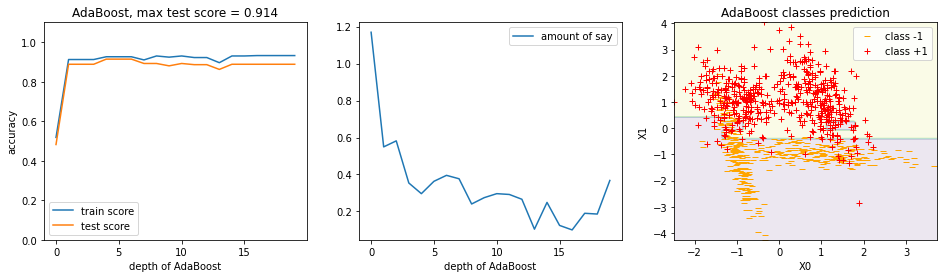

In [11]:
def ab_back_ground(x_min, x_max, y_min, y_max, model, n):
    step = 100

    xx, yy = np.meshgrid(
                        np.arange(x_min, x_max + (x_max-x_min) / step, (x_max-x_min) / step),
                        np.arange(y_min, y_max + (y_max-y_min) / step, (y_max-y_min) / step)
                        )

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()], n)
    Z = Z.reshape(xx.shape)    
    
    return xx, yy, Z

def plot_three_some():
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

    axes[0].plot(machines, ab_train_score, label="train score")
    axes[0].plot(machines, ab_test_score, label="test score")

    axes[0].set_ylabel("accuracy")
    axes[0].set_xlabel("depth of AdaBoost")
    axes[0].set_title("AdaBoost, max test score = " + str(max(ab_test_score)))
    axes[0].set_ylim(0, 1.1)
    axes[0].legend()

    axes[1].plot(ab_clf.asay, label="amount of say")
    axes[1].set_xlabel("depth of AdaBoost")
    axes[1].legend()

    xx, yy, Z = ab_back_ground(min(X[:, 0]), max(X[:, 0]), min(X[:, 1]), max(X[:, 1]),
                               ab_clf, ab_clf.n_estimators)

    axes[2].plot(X[y==0, 0], X[y==0, 1], "_", color='orange', label="class -1")
    axes[2].plot(X[y==1, 0], X[y==1, 1], "+", color='red', label="class +1")
    axes[2].set_xlabel("X0")
    axes[2].set_ylabel("X1")
    axes[2].set_title("AdaBoost classes prediction")
    axes[2].contourf(xx, yy, Z, alpha=0.1)

    axes[2].legend()
    plt.show()
    
plot_three_some()

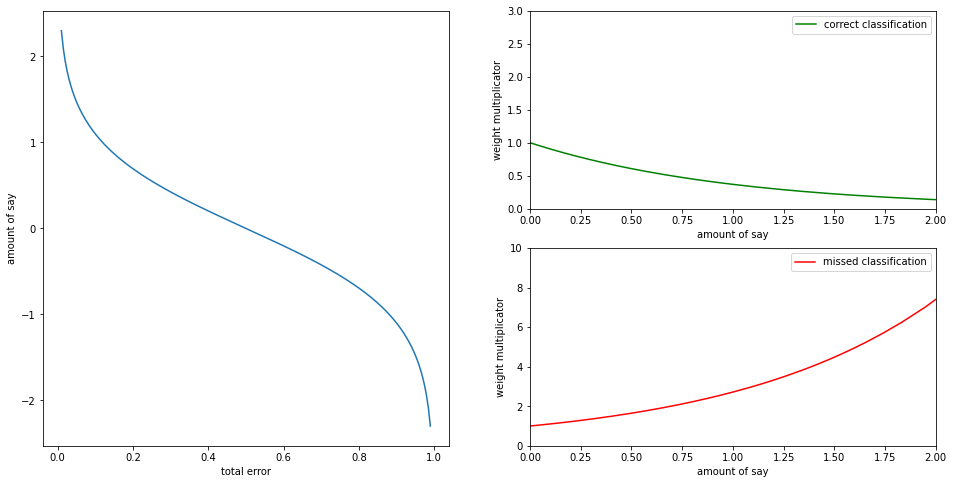

In [76]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2)

e = 1e-7
total_error = np.linspace(0.01, 0.99, 200)
amount_of_say = 0.5 * np.log((1 - total_error) / (total_error + e))

ax = fig.add_subplot(gs[:, 0])
ax.plot(total_error, amount_of_say)
ax.set_xlabel("total error")
ax.set_ylabel("amount of say")

ax = fig.add_subplot(gs[0, 1])
ax.plot(amount_of_say, np.exp((-1) * amount_of_say), "green", label="correct classification")
ax.set_xlabel("amount of say")
ax.set_ylabel("weight multiplicator")
ax.set_xlim(0, 2)
ax.set_ylim(0, 3)
plt.legend()

ax = fig.add_subplot(gs[1, 1])
ax.plot(amount_of_say, np.exp((+1) * amount_of_say), "red", label="missed classification")
ax.set_xlabel("amount of say")
ax.set_ylabel("weight multiplicator")
ax.set_xlim(0, 2)
ax.set_ylim(0, 10)
plt.legend()

plt.show()